# "Vega at a Glance"
Let's see how well we can replicate mapd's vega examples by doing all the charting client side with altair. Why? Well then we can use all the regular vega lite interactive magic and not have to worry about their custom vega spec.

We will start with their plot of tweets in europe:

https://www.mapd.com/docs/latest/mapd-core-guide/vegaAtaGlance/

![](https://www.mapd.com/docs/latest/_images/demoScreenshot.png)

This is the vega they use to create it:


```javascript
const exampleVega = {
  "width": 384,
  "height": 564,
  "data": [
    {
      "name": "tweets",
      "sql": "SELECT goog_x as x, goog_y as y, tweets_nov_feb.rowid FROM tweets_nov_feb"
    }
  ],
  "scales": [
    {
      "name": "x",
      "type": "linear",
      "domain": [
        -3650484.1235206556,
        7413325.514451755
      ],
      "range": "width"
    },
    {
      "name": "y",
      "type": "linear",
      "domain": [
        -5778161.9183506705,
        10471808.487466192
      ],
      "range": "height"
    }
  ],
  "marks": [
    {
      "type": "points",
      "from": {
        "data": "tweets"
      },
      "properties": {
        "x": {
          "scale": "x",
          "field": "x"
        },
        "y": {
          "scale": "y",
          "field": "y"
        },
        "fillColor": "blue",
        "size": {
          "value": 3
        }
      }
    }
  ]
};
```

Let's replicate that query and see how many results there are:

In [1]:
import ibis
import altair as alt

In [15]:
conn = ibis.mapd.connect(
    host='metis.mapd.com', user='mapd', password='HyperInteractive',
    port=443, database='mapd', protocol= 'https'
)

In [16]:
t = conn.table('tweets_nov_feb')
t

DatabaseTable[table]
  name: tweets_nov_feb
  schema:
    tweet_id : int64
    tweet_time : timestamp
    lat : float
    lon : float
    sender_id : int64
    sender_name : string
    location : string
    source : string
    reply_to_user_id : int64
    reply_to_tweet_id : int64
    lang : string
    followers : int32
    followees : int32
    tweet_count : int32
    join_time : timestamp
    tweet_text : string
    country : string
    admin1 : string
    admin2 : string
    place_name : string
    state_abbr : string
    county_state : string
    origin : string
    hashtags : string
    tweet_tokens : string
    goog_x : float
    goog_y : float

In [17]:
expr = t[
    t.goog_x.name('x'),
    t.goog_y.name('y'),
]

print(expr.compile())

SELECT "goog_x" AS x, "goog_y" AS y
FROM tweets_nov_feb


In [18]:
expr.count().execute()

572002

We don't really wanna get all 500k+ results at once. I don't think we can. Well, let's try it

In [19]:
df = expr.execute()

In [20]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 2 columns):
x    10000 non-null float32
y    10000 non-null float32
dtypes: float32(2)
memory usage: 78.2 KB


Yeah, we only get the first 10,000 at a time. So there isn't really a way to get them all... Except in the visualization we are restricting the x and y to a certain domain. So let's filter and see how many that gets us.

In [23]:
expr_f = t[
    t.goog_x.between(-3650484.1235206556, 7413325.514451755).name('x'),
    t.goog_y.between(-5778161.9183506705, 10471808.487466192).name('y'),
]

print(expr_f.compile())

SELECT "goog_x" BETWEEN -3650484.1235206556 AND 7413325.514451755 AS x,
       "goog_y" BETWEEN -5778161.9183506705 AND 10471808.487466192 AS y
FROM tweets_nov_feb


In [25]:
expr_f.count().execute()

572002

OK, that's weird, it's the same count. Let's graph the results of both queries to see if they really are the same:

In [26]:
alt.data_transformers.enable('json')

DataTransformerRegistry.enable('json')

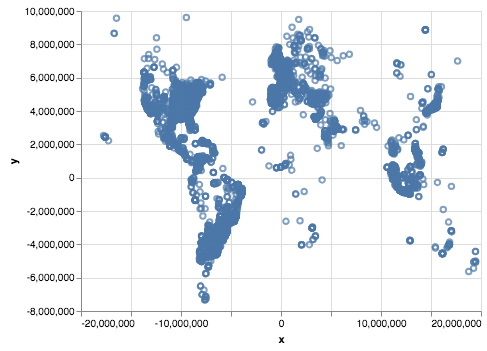

In [27]:
alt.Chart(expr.execute()).mark_point().encode(
    x='x:Q',
    y='y:Q'
)

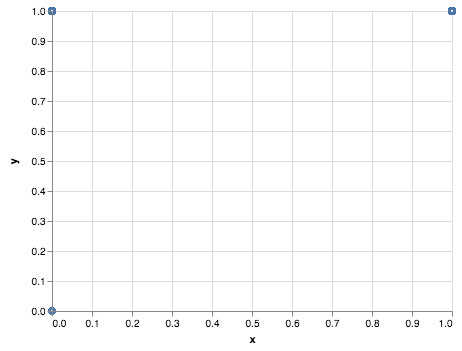

In [28]:
alt.Chart(expr_f.execute()).mark_point().encode(
    x='x:Q',
    y='y:Q'
)

OK the first one looks good, but the second doesn't seem quite right :) Let's look at the data

In [29]:
expr_f.execute().head()

,x,y
0,True,True
1,True,True
2,False,True
3,True,True
4,True,True


Ah looks like I don't know SQL very well. OK looking at the ibis docs (http://docs.ibis-project.org/sql.html?highlight=where#filtering-where) let's change that expr_f to actually filter.

In [33]:
expr_f = expr.filter([
    expr.x.between(-3650484.1235206556, 7413325.514451755),
    expr.y.between(5778161.9183506705, 10471808.487466192)
])
print(expr_f.compile())

SELECT *
FROM (
  SELECT "goog_x" AS x, "goog_y" AS y
  FROM tweets_nov_feb
) t0
WHERE ("x" BETWEEN -3650484.1235206556 AND 7413325.514451755) AND
      ("y" BETWEEN 5778161.9183506705 AND 10471808.487466192)


In [34]:
expr_f.count().execute()

63646

OK that's better... but it's still more than the 10k max we get back when we plot it. Let's just look at what is.

In [36]:
df_f = expr_f.execute()

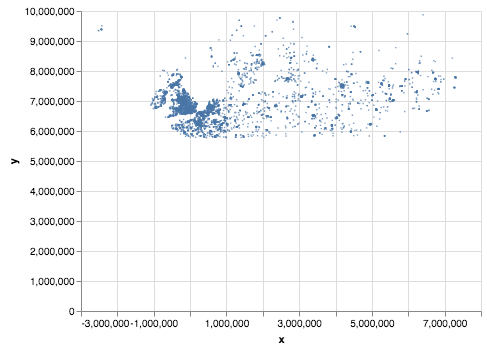

In [40]:
alt.Chart(df_f).mark_square(size=2).encode(x='x', y='y').interactive()

OK cool! We are getting like a part of the plot that we want... So how do we get all the points? Can we somehow aggregate by pixel on the backend? 

Or can we somehow get a sample of the total? And then get more as we zoom in?